<a href="https://colab.research.google.com/github/YeyoM/Time_Series_Forecast_ML/blob/main/RNNs_time_series_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting time series using RNNs 

This colab is the second part of [Recurrent Neural Network colab](https://colab.research.google.com/drive/11ryebHxiyOqQd3M1NfsTyCgPEJqXaf1W#scrollTo=PG4OwzAlLyr-).

In this colab we will apply the concepts learned from the prevoius colabs about time series forecasting.




### Setup

Basic functions to create and plot time series

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format = "-", start = 0, end = None, label = None):
    plt.plot(time[start:end], series[start:end], format, label = label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize = 14)
    plt.grid(True)
    
def trend(time, slope = 0):
    return slope * time
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
  
def seasonality(time, period, amplitude = 1, phase = 0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level = 1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  
  
def window_dataset(series, window_size, batch_size = 32,
                   shuffle_buffer = 1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

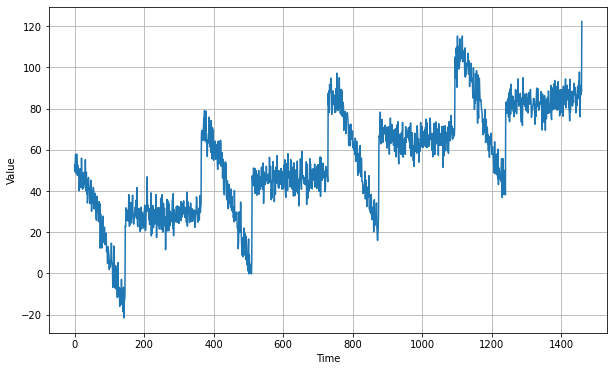

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize = (10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Simple RNN

In [5]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1),
                      input_shape = [None]), # convert from 2dim to 3dim for the RNN
  keras.layers.SimpleRNN(100, return_sequences = True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1), # output layer between -1 to 1
  keras.layers.Lambda(lambda x: x * 200.0)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20)
)

optimizer = keras.optimizers.SGD(lr = 1e-7, momentum = 0.9)

model.compile(
    loss = keras.losses.Huber(),
    optimizer = optimizer,
    metrics = ["mae"]
)

history = model.fit(train_set, epochs = 100, callbacks = [lr_schedule])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1/100
8/8 [==============================] - 3s 88ms/step - loss: 276.9856 - mae: 277.4856 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 37ms/step - loss: 186.9863 - mae: 187.4863 - lr: 1.1220e-07
Epoch 3/100
8/8 [==============================] - 1s 62ms/step - loss: 68.2398 - mae: 68.7386 - lr: 1.2589e-07
Epoch 4/100
8/8 [==============================] - 1s 62ms/step - loss: 43.9882 - mae: 44.4867 - lr: 1.4125e-07
Epoch 5/100
8/8 [==============================] - 0s 39ms/step - loss: 37.5820 - mae: 38.0806 - lr: 1.5849e-07
Epoch 6/100
8/8 [==============================] - 1s 39ms/step - loss: 24.3121 - mae: 24.8039 - lr: 1.7783e-07
Epoch 7/100
8/8 [==============================] - 0s 39ms/step - loss: 20.0694 - mae: 20.5636 - lr: 1.9953e-07
Epoch 8/100
8/8 [==============================] - 1s 44ms/step - loss: 17.6145 - mae: 18.1060 - lr: 2.2387e-07
Epoch 9/100
8/8 [==============================] - 1s 39ms/step - loss: 15.9334 - mae: 16.4247 - lr:

(1e-07, 0.0001, 0.0, 30.0)

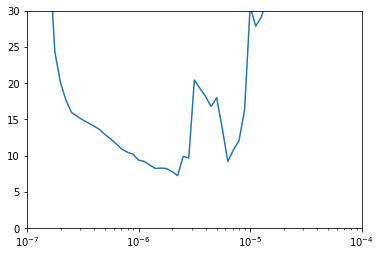

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

Now lets try again but now with a validation set, an early stopping function and a model checkpoint to save the model every time it improves.

In [13]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size = 128)
valid_set = window_dataset(x_valid, window_size, batch_size = 128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1),
                      input_shape = [None]),
  keras.layers.SimpleRNN(100, return_sequences = True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])

optimizer = keras.optimizers.SGD(learning_rate = 1.5e-6, momentum = 0.9)

model.compile(
    loss = keras.losses.Huber(),
    optimizer = optimizer,
    metrics = ["mae"]
)

early_stopping = keras.callbacks.EarlyStopping(patience = 50)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", 
    save_best_only = True
)

model.fit(
    train_set, 
    epochs = 500,
    validation_data = valid_set,
    callbacks = [early_stopping, model_checkpoint]
)

Epoch 1/500
      7/Unknown - 3s 36ms/step - loss: 169.2382 - mae: 169.7375

8/8 [==============================] - 6s 498ms/step - loss: 158.8854 - mae: 159.3847 - val_loss: 19.6909 - val_mae: 20.1863
Epoch 2/500
8/8 [==============================] - 1s 115ms/step - loss: 80.3054 - mae: 80.8044 - val_loss: 44.2080 - val_mae: 44.7080
Epoch 3/500
8/8 [==============================] - 1s 88ms/step - loss: 44.1803 - mae: 44.6777 - val_loss: 37.5831 - val_mae: 38.0830
Epoch 4/500
8/8 [==============================] - 1s 50ms/step - loss: 28.4053 - mae: 28.8998 - val_loss: 43.6123 - val_mae: 44.1123
Epoch 5/500
7/8 [=========================>....] - ETA: 0s - loss: 20.2597 - mae: 20.7541

8/8 [==============================] - 3s 472ms/step - loss: 20.2511 - mae: 20.7456 - val_loss: 11.5241 - val_mae: 12.0190
Epoch 6/500
7/8 [=========================>....] - ETA: 0s - loss: 14.9675 - mae: 15.4616

8/8 [==============================] - 3s 429ms/step - loss: 14.9794 - mae: 15.4732 - val_loss: 9.1624 - val_mae: 9.6496
Epoch 7/500
8/8 [==============================] - 1s 58ms/step - loss: 13.2778 - mae: 13.7690 - val_loss: 9.2645 - val_mae: 9.7543
Epoch 8/500
8/8 [==============================] - 1s 54ms/step - loss: 10.7730 - mae: 11.2635 - val_loss: 9.5983 - val_mae: 10.0880
Epoch 9/500
8/8 [==============================] - 1s 59ms/step - loss: 9.2020 - mae: 9.6876 - val_loss: 11.3850 - val_mae: 11.8779
Epoch 10/500
8/8 [==============================] - 1s 53ms/step - loss: 8.7040 - mae: 9.1876 - val_loss: 11.7397 - val_mae: 12.2344
Epoch 11/500
8/8 [==============================] - 1s 94ms/step - loss: 8.4976 - mae: 8.9802 - val_loss: 10.1792 - val_mae: 10.6691
Epoch 12/500
7/8 [=========================>....] - ETA: 0s - loss: 8.1486 - mae: 8.6328

8/8 [==============================] - 4s 488ms/step - loss: 8.0735 - mae: 8.5569 - val_loss: 8.5496 - val_mae: 9.0375
Epoch 13/500
7/8 [=========================>....] - ETA: 0s - loss: 7.8670 - mae: 8.3471

8/8 [==============================] - 4s 498ms/step - loss: 7.8668 - mae: 8.3474 - val_loss: 7.7899 - val_mae: 8.2738
Epoch 14/500
8/8 [==============================] - 1s 54ms/step - loss: 7.7700 - mae: 8.2527 - val_loss: 8.8337 - val_mae: 9.3200
Epoch 15/500
7/8 [=========================>....] - ETA: 0s - loss: 7.0863 - mae: 7.5689

8/8 [==============================] - 3s 430ms/step - loss: 7.4492 - mae: 7.9320 - val_loss: 7.3636 - val_mae: 7.8535
Epoch 16/500
8/8 [==============================] - 1s 51ms/step - loss: 7.3659 - mae: 7.8470 - val_loss: 7.7286 - val_mae: 8.2133
Epoch 17/500
8/8 [==============================] - 1s 53ms/step - loss: 7.3763 - mae: 7.8576 - val_loss: 9.6229 - val_mae: 10.1180
Epoch 18/500
7/8 [=========================>....] - ETA: 0s - loss: 7.4901 - mae: 7.9755

8/8 [==============================] - 4s 493ms/step - loss: 7.5360 - mae: 8.0218 - val_loss: 7.3198 - val_mae: 7.8111
Epoch 19/500
8/8 [==============================] - 1s 54ms/step - loss: 6.9908 - mae: 7.4719 - val_loss: 7.9283 - val_mae: 8.4145
Epoch 20/500
7/8 [=========================>....] - ETA: 0s - loss: 6.8988 - mae: 7.3829

8/8 [==============================] - 4s 487ms/step - loss: 6.9194 - mae: 7.4035 - val_loss: 6.9333 - val_mae: 7.4180
Epoch 21/500
7/8 [=========================>....] - ETA: 0s - loss: 6.7418 - mae: 7.2198

8/8 [==============================] - 4s 565ms/step - loss: 6.7463 - mae: 7.2256 - val_loss: 6.1960 - val_mae: 6.6788
Epoch 22/500
8/8 [==============================] - 1s 55ms/step - loss: 6.9995 - mae: 7.4803 - val_loss: 7.6639 - val_mae: 8.1461
Epoch 23/500
8/8 [==============================] - 1s 56ms/step - loss: 6.7735 - mae: 7.2575 - val_loss: 6.7026 - val_mae: 7.1805
Epoch 24/500
8/8 [==============================] - 1s 57ms/step - loss: 6.7017 - mae: 7.1857 - val_loss: 7.6423 - val_mae: 8.1242
Epoch 25/500
8/8 [==============================] - 1s 57ms/step - loss: 6.4989 - mae: 6.9798 - val_loss: 6.8753 - val_mae: 7.3637
Epoch 26/500
8/8 [==============================] - 1s 62ms/step - loss: 6.3627 - mae: 6.8410 - val_loss: 7.0086 - val_mae: 7.5001
Epoch 27/500
7/8 [=========================>....] - ETA: 0s - loss: 6.4290 - mae: 6.9081

8/8 [==============================] - 3s 433ms/step - loss: 6.4413 - mae: 6.9203 - val_loss: 6.1664 - val_mae: 6.6441
Epoch 28/500
8/8 [==============================] - 1s 82ms/step - loss: 6.3540 - mae: 6.8357 - val_loss: 7.4443 - val_mae: 7.9296
Epoch 29/500
7/8 [=========================>....] - ETA: 0s - loss: 6.2456 - mae: 6.7286

8/8 [==============================] - 4s 485ms/step - loss: 6.3733 - mae: 6.8562 - val_loss: 5.7939 - val_mae: 6.2741
Epoch 30/500
8/8 [==============================] - 1s 53ms/step - loss: 6.2815 - mae: 6.7569 - val_loss: 8.3355 - val_mae: 8.8247
Epoch 31/500
8/8 [==============================] - 1s 52ms/step - loss: 6.2893 - mae: 6.7667 - val_loss: 5.8045 - val_mae: 6.2858
Epoch 32/500
8/8 [==============================] - 1s 55ms/step - loss: 6.5573 - mae: 7.0434 - val_loss: 7.7835 - val_mae: 8.2630
Epoch 33/500
8/8 [==============================] - 1s 54ms/step - loss: 6.0590 - mae: 6.5383 - val_loss: 7.4356 - val_mae: 7.9184
Epoch 34/500
8/8 [==============================] - 1s 53ms/step - loss: 6.0496 - mae: 6.5261 - val_loss: 6.0692 - val_mae: 6.5466
Epoch 35/500
8/8 [==============================] - 1s 53ms/step - loss: 5.9971 - mae: 6.4736 - val_loss: 5.9032 - val_mae: 6.3850
Epoch 36/500
8/8 [==============================] - 1s 51ms/step - loss: 5.9400 - mae: 6.4188 -

8/8 [==============================] - 4s 609ms/step - loss: 6.0181 - mae: 6.4951 - val_loss: 5.7239 - val_mae: 6.2076
Epoch 38/500
7/8 [=========================>....] - ETA: 0s - loss: 5.8914 - mae: 6.3686

8/8 [==============================] - 3s 432ms/step - loss: 5.9166 - mae: 6.3929 - val_loss: 5.6427 - val_mae: 6.1264
Epoch 39/500
8/8 [==============================] - 1s 57ms/step - loss: 6.0788 - mae: 6.5604 - val_loss: 8.1251 - val_mae: 8.6137
Epoch 40/500
7/8 [=========================>....] - ETA: 0s - loss: 6.3398 - mae: 6.8204

8/8 [==============================] - 4s 492ms/step - loss: 6.2825 - mae: 6.7630 - val_loss: 5.5419 - val_mae: 6.0156
Epoch 41/500
8/8 [==============================] - 1s 58ms/step - loss: 6.0551 - mae: 6.5330 - val_loss: 6.3844 - val_mae: 6.8657
Epoch 42/500
8/8 [==============================] - 1s 54ms/step - loss: 5.8304 - mae: 6.3072 - val_loss: 6.0284 - val_mae: 6.5069
Epoch 43/500
7/8 [=========================>....] - ETA: 0s - loss: 5.9198 - mae: 6.3974

8/8 [==============================] - 4s 561ms/step - loss: 5.8950 - mae: 6.3731 - val_loss: 5.5170 - val_mae: 5.9919
Epoch 44/500
8/8 [==============================] - 1s 52ms/step - loss: 5.9341 - mae: 6.4144 - val_loss: 6.6268 - val_mae: 7.1164
Epoch 45/500
8/8 [==============================] - 1s 52ms/step - loss: 5.6729 - mae: 6.1508 - val_loss: 5.6204 - val_mae: 6.1051
Epoch 46/500
8/8 [==============================] - 1s 50ms/step - loss: 5.7581 - mae: 6.2385 - val_loss: 5.6609 - val_mae: 6.1432
Epoch 47/500
8/8 [==============================] - 1s 55ms/step - loss: 6.0393 - mae: 6.5230 - val_loss: 8.0418 - val_mae: 8.5321
Epoch 48/500
8/8 [==============================] - 1s 54ms/step - loss: 5.8912 - mae: 6.3725 - val_loss: 5.7571 - val_mae: 6.2319
Epoch 49/500
8/8 [==============================] - 1s 54ms/step - loss: 5.6374 - mae: 6.1129 - val_loss: 5.9640 - val_mae: 6.4429
Epoch 50/500
7/8 [=========================>....] - ETA: 0s - loss: 5.7817 - mae: 6.2625

8/8 [==============================] - 4s 482ms/step - loss: 5.8235 - mae: 6.3044 - val_loss: 5.4023 - val_mae: 5.8838
Epoch 51/500
8/8 [==============================] - 1s 56ms/step - loss: 6.3890 - mae: 6.8712 - val_loss: 5.5392 - val_mae: 6.0263
Epoch 52/500
8/8 [==============================] - 1s 55ms/step - loss: 5.8832 - mae: 6.3591 - val_loss: 6.6516 - val_mae: 7.1393
Epoch 53/500
8/8 [==============================] - 1s 55ms/step - loss: 5.6574 - mae: 6.1368 - val_loss: 6.6567 - val_mae: 7.1447
Epoch 54/500
8/8 [==============================] - 1s 88ms/step - loss: 6.1541 - mae: 6.6351 - val_loss: 5.6571 - val_mae: 6.1435
Epoch 55/500
8/8 [==============================] - 1s 90ms/step - loss: 5.7021 - mae: 6.1766 - val_loss: 6.1841 - val_mae: 6.6647
Epoch 56/500
8/8 [==============================] - 1s 57ms/step - loss: 5.4578 - mae: 5.9355 - val_loss: 5.8928 - val_mae: 6.3713
Epoch 57/500
7/8 [=========================>....] - ETA: 0s - loss: 5.4694 - mae: 5.9475

8/8 [==============================] - 3s 436ms/step - loss: 5.4714 - mae: 5.9493 - val_loss: 5.3604 - val_mae: 5.8422
Epoch 58/500
8/8 [==============================] - 1s 54ms/step - loss: 5.8639 - mae: 6.3442 - val_loss: 6.9553 - val_mae: 7.4403
Epoch 59/500
8/8 [==============================] - 1s 54ms/step - loss: 5.3697 - mae: 5.8452 - val_loss: 6.2249 - val_mae: 6.7040
Epoch 60/500
8/8 [==============================] - 1s 55ms/step - loss: 5.4221 - mae: 5.9002 - val_loss: 5.5764 - val_mae: 6.0558
Epoch 61/500
8/8 [==============================] - 1s 58ms/step - loss: 5.3186 - mae: 5.7942 - val_loss: 5.4053 - val_mae: 5.8908
Epoch 62/500
8/8 [==============================] - 1s 56ms/step - loss: 5.5103 - mae: 5.9860 - val_loss: 6.0795 - val_mae: 6.5559
Epoch 63/500
8/8 [==============================] - 1s 52ms/step - loss: 5.4724 - mae: 5.9539 - val_loss: 5.7991 - val_mae: 6.2859
Epoch 64/500
8/8 [==============================] - 1s 70ms/step - loss: 5.6466 - mae: 6.1250 -

8/8 [==============================] - 3s 428ms/step - loss: 5.1617 - mae: 5.6412 - val_loss: 5.2454 - val_mae: 5.7264
Epoch 68/500
8/8 [==============================] - 1s 52ms/step - loss: 5.4988 - mae: 5.9806 - val_loss: 5.4399 - val_mae: 5.9245
Epoch 69/500
8/8 [==============================] - 1s 55ms/step - loss: 5.1852 - mae: 5.6625 - val_loss: 5.4184 - val_mae: 5.9015
Epoch 70/500
8/8 [==============================] - 1s 52ms/step - loss: 5.4046 - mae: 5.8805 - val_loss: 7.1880 - val_mae: 7.6710
Epoch 71/500
8/8 [==============================] - 1s 51ms/step - loss: 5.4060 - mae: 5.8832 - val_loss: 5.6018 - val_mae: 6.0865
Epoch 72/500
8/8 [==============================] - 1s 54ms/step - loss: 5.7158 - mae: 6.1946 - val_loss: 6.0461 - val_mae: 6.5246
Epoch 73/500
8/8 [==============================] - 1s 56ms/step - loss: 5.2172 - mae: 5.6990 - val_loss: 5.7471 - val_mae: 6.2260
Epoch 74/500
8/8 [==============================] - 1s 53ms/step - loss: 5.0662 - mae: 5.5428 -

8/8 [==============================] - 4s 492ms/step - loss: 5.3998 - mae: 5.8810 - val_loss: 5.2304 - val_mae: 5.7100
Epoch 79/500
8/8 [==============================] - 1s 54ms/step - loss: 5.5082 - mae: 5.9873 - val_loss: 5.2544 - val_mae: 5.7294
Epoch 80/500
8/8 [==============================] - 1s 59ms/step - loss: 5.1555 - mae: 5.6341 - val_loss: 6.4533 - val_mae: 6.9379
Epoch 81/500
7/8 [=========================>....] - ETA: 0s - loss: 4.9724 - mae: 5.4524

8/8 [==============================] - 3s 425ms/step - loss: 5.0113 - mae: 5.4908 - val_loss: 5.1796 - val_mae: 5.6531
Epoch 82/500
8/8 [==============================] - 1s 60ms/step - loss: 5.2768 - mae: 5.7516 - val_loss: 5.8203 - val_mae: 6.2991
Epoch 83/500
8/8 [==============================] - 1s 52ms/step - loss: 5.2221 - mae: 5.7024 - val_loss: 5.5315 - val_mae: 6.0098
Epoch 84/500
8/8 [==============================] - 1s 96ms/step - loss: 4.9275 - mae: 5.4091 - val_loss: 5.2511 - val_mae: 5.7282
Epoch 85/500
8/8 [==============================] - 1s 104ms/step - loss: 4.9305 - mae: 5.4095 - val_loss: 5.3530 - val_mae: 5.8330
Epoch 86/500
7/8 [=========================>....] - ETA: 0s - loss: 5.0183 - mae: 5.4980

8/8 [==============================] - 4s 531ms/step - loss: 5.0070 - mae: 5.4863 - val_loss: 5.1734 - val_mae: 5.6533
Epoch 87/500
8/8 [==============================] - 1s 54ms/step - loss: 4.8953 - mae: 5.3726 - val_loss: 5.2002 - val_mae: 5.6773
Epoch 88/500
7/8 [=========================>....] - ETA: 0s - loss: 4.9192 - mae: 5.3944

8/8 [==============================] - 3s 448ms/step - loss: 5.0061 - mae: 5.4823 - val_loss: 5.1560 - val_mae: 5.6300
Epoch 89/500
8/8 [==============================] - 1s 111ms/step - loss: 5.0567 - mae: 5.5336 - val_loss: 5.5992 - val_mae: 6.0793
Epoch 90/500
8/8 [==============================] - ETA: 0s - loss: 4.9260 - mae: 5.4078

8/8 [==============================] - 4s 582ms/step - loss: 4.9260 - mae: 5.4078 - val_loss: 5.0717 - val_mae: 5.5552
Epoch 91/500
8/8 [==============================] - 1s 55ms/step - loss: 4.8394 - mae: 5.3152 - val_loss: 6.4933 - val_mae: 6.9792
Epoch 92/500
8/8 [==============================] - 1s 53ms/step - loss: 4.9743 - mae: 5.4481 - val_loss: 5.3401 - val_mae: 5.8199
Epoch 93/500
8/8 [==============================] - 1s 55ms/step - loss: 4.8819 - mae: 5.3593 - val_loss: 5.0963 - val_mae: 5.5707
Epoch 94/500
8/8 [==============================] - 1s 56ms/step - loss: 5.3678 - mae: 5.8419 - val_loss: 10.8948 - val_mae: 11.3897
Epoch 95/500
8/8 [==============================] - 1s 57ms/step - loss: 6.1111 - mae: 6.5952 - val_loss: 5.8168 - val_mae: 6.3043
Epoch 96/500
8/8 [==============================] - 1s 59ms/step - loss: 5.4418 - mae: 5.9177 - val_loss: 8.7333 - val_mae: 9.2255
Epoch 97/500
8/8 [==============================] - 1s 55ms/step - loss: 5.4081 - mae: 5.8901

8/8 [==============================] - 4s 561ms/step - loss: 4.8839 - mae: 5.3585 - val_loss: 5.0533 - val_mae: 5.5363
Epoch 103/500
8/8 [==============================] - 1s 58ms/step - loss: 4.7634 - mae: 5.2413 - val_loss: 5.8981 - val_mae: 6.3770
Epoch 104/500
8/8 [==============================] - 1s 53ms/step - loss: 4.7480 - mae: 5.2269 - val_loss: 5.2420 - val_mae: 5.7259
Epoch 105/500
8/8 [==============================] - 1s 56ms/step - loss: 4.8093 - mae: 5.2878 - val_loss: 5.1974 - val_mae: 5.6762
Epoch 106/500
8/8 [==============================] - 1s 58ms/step - loss: 4.6763 - mae: 5.1532 - val_loss: 5.6021 - val_mae: 6.0831
Epoch 107/500
8/8 [==============================] - 1s 53ms/step - loss: 4.7415 - mae: 5.2151 - val_loss: 5.1348 - val_mae: 5.6124
Epoch 108/500
8/8 [==============================] - 1s 56ms/step - loss: 4.6488 - mae: 5.1274 - val_loss: 5.1158 - val_mae: 5.5924
Epoch 109/500
8/8 [==============================] - 1s 59ms/step - loss: 4.6782 - mae: 5

8/8 [==============================] - 3s 442ms/step - loss: 4.9557 - mae: 5.4316 - val_loss: 5.0491 - val_mae: 5.5232
Epoch 112/500
8/8 [==============================] - 1s 83ms/step - loss: 4.7199 - mae: 5.1860 - val_loss: 6.9729 - val_mae: 7.4609
Epoch 113/500
8/8 [==============================] - 1s 52ms/step - loss: 5.0603 - mae: 5.5378 - val_loss: 5.5243 - val_mae: 6.0075
Epoch 114/500
8/8 [==============================] - 1s 55ms/step - loss: 4.9144 - mae: 5.3916 - val_loss: 6.7356 - val_mae: 7.2225
Epoch 115/500
8/8 [==============================] - 1s 52ms/step - loss: 4.9695 - mae: 5.4464 - val_loss: 5.4666 - val_mae: 5.9440
Epoch 116/500
7/8 [=========================>....] - ETA: 0s - loss: 4.5578 - mae: 5.0340

8/8 [==============================] - 4s 502ms/step - loss: 4.6162 - mae: 5.0930 - val_loss: 4.9583 - val_mae: 5.4425
Epoch 117/500
8/8 [==============================] - 1s 57ms/step - loss: 4.7872 - mae: 5.2620 - val_loss: 5.1119 - val_mae: 5.5918
Epoch 118/500
8/8 [==============================] - 1s 55ms/step - loss: 5.3471 - mae: 5.8236 - val_loss: 5.8342 - val_mae: 6.3133
Epoch 119/500
8/8 [==============================] - 1s 58ms/step - loss: 5.2283 - mae: 5.7088 - val_loss: 5.0339 - val_mae: 5.5163
Epoch 120/500
8/8 [==============================] - 1s 60ms/step - loss: 4.9089 - mae: 5.3862 - val_loss: 6.0947 - val_mae: 6.5722
Epoch 121/500
8/8 [==============================] - 1s 110ms/step - loss: 4.5798 - mae: 5.0622 - val_loss: 5.0371 - val_mae: 5.5208
Epoch 122/500
8/8 [==============================] - 1s 93ms/step - loss: 4.8251 - mae: 5.3028 - val_loss: 6.4692 - val_mae: 6.9537
Epoch 123/500
8/8 [==============================] - 1s 57ms/step - loss: 4.8392 - mae: 

8/8 [==============================] - 3s 466ms/step - loss: 4.4829 - mae: 4.9548 - val_loss: 4.9573 - val_mae: 5.4380
Epoch 131/500
7/8 [=========================>....] - ETA: 0s - loss: 5.0346 - mae: 5.5130

8/8 [==============================] - 4s 483ms/step - loss: 5.0519 - mae: 5.5300 - val_loss: 4.9438 - val_mae: 5.4236
Epoch 132/500
8/8 [==============================] - 1s 53ms/step - loss: 4.7292 - mae: 5.2038 - val_loss: 5.1346 - val_mae: 5.6144
Epoch 133/500
8/8 [==============================] - 1s 57ms/step - loss: 4.4091 - mae: 4.8847 - val_loss: 5.1954 - val_mae: 5.6760
Epoch 134/500
8/8 [==============================] - 1s 60ms/step - loss: 4.4389 - mae: 4.9161 - val_loss: 4.9470 - val_mae: 5.4315
Epoch 135/500
8/8 [==============================] - 1s 55ms/step - loss: 4.5007 - mae: 4.9696 - val_loss: 5.5852 - val_mae: 6.0623
Epoch 136/500
8/8 [==============================] - 1s 55ms/step - loss: 4.4152 - mae: 4.8915 - val_loss: 5.0304 - val_mae: 5.5098
Epoch 137/500
8/8 [==============================] - 1s 56ms/step - loss: 4.5595 - mae: 5.0378 - val_loss: 5.2291 - val_mae: 5.7084
Epoch 138/500
8/8 [==============================] - 1s 55ms/step - loss: 4.5664 - mae: 5

8/8 [==============================] - 3s 450ms/step - loss: 4.9571 - mae: 5.4357 - val_loss: 4.9326 - val_mae: 5.4153
Epoch 144/500
8/8 [==============================] - 1s 56ms/step - loss: 4.5332 - mae: 5.0094 - val_loss: 4.9704 - val_mae: 5.4532
Epoch 145/500
8/8 [==============================] - 1s 57ms/step - loss: 4.7050 - mae: 5.1832 - val_loss: 5.7913 - val_mae: 6.2707
Epoch 146/500
8/8 [==============================] - 1s 53ms/step - loss: 4.4418 - mae: 4.9114 - val_loss: 4.9408 - val_mae: 5.4221
Epoch 147/500
8/8 [==============================] - 1s 58ms/step - loss: 4.4376 - mae: 4.9147 - val_loss: 6.2504 - val_mae: 6.7311
Epoch 148/500
8/8 [==============================] - 1s 57ms/step - loss: 4.4531 - mae: 4.9277 - val_loss: 5.1819 - val_mae: 5.6614
Epoch 149/500
8/8 [==============================] - 1s 54ms/step - loss: 4.5939 - mae: 5.0641 - val_loss: 5.0477 - val_mae: 5.5263
Epoch 150/500
8/8 [==============================] - 1s 54ms/step - loss: 4.8490 - mae: 5

8/8 [==============================] - 4s 505ms/step - loss: 4.3958 - mae: 4.8704 - val_loss: 4.8879 - val_mae: 5.3700
Epoch 163/500
8/8 [==============================] - 1s 83ms/step - loss: 4.2801 - mae: 4.7564 - val_loss: 5.0598 - val_mae: 5.5407
Epoch 164/500
8/8 [==============================] - 1s 110ms/step - loss: 4.3230 - mae: 4.7971 - val_loss: 4.9068 - val_mae: 5.3834
Epoch 165/500
8/8 [==============================] - 1s 106ms/step - loss: 4.4718 - mae: 4.9476 - val_loss: 5.1447 - val_mae: 5.6224
Epoch 166/500
8/8 [==============================] - 1s 61ms/step - loss: 4.3061 - mae: 4.7768 - val_loss: 4.9636 - val_mae: 5.4431
Epoch 167/500
8/8 [==============================] - 1s 54ms/step - loss: 4.6170 - mae: 5.0904 - val_loss: 6.4977 - val_mae: 6.9830
Epoch 168/500
8/8 [==============================] - 1s 54ms/step - loss: 4.3459 - mae: 4.8190 - val_loss: 5.1696 - val_mae: 5.6506
Epoch 169/500
8/8 [==============================] - 1s 59ms/step - loss: 4.5048 - mae:

8/8 [==============================] - 3s 446ms/step - loss: 4.3045 - mae: 4.7764 - val_loss: 4.8782 - val_mae: 5.3592
Epoch 185/500
8/8 [==============================] - 1s 56ms/step - loss: 4.3709 - mae: 4.8418 - val_loss: 6.6527 - val_mae: 7.1415
Epoch 186/500
8/8 [==============================] - 1s 52ms/step - loss: 4.4128 - mae: 4.8900 - val_loss: 5.0431 - val_mae: 5.5237
Epoch 187/500
8/8 [==============================] - 1s 58ms/step - loss: 4.1652 - mae: 4.6396 - val_loss: 6.4211 - val_mae: 6.9049
Epoch 188/500
8/8 [==============================] - 1s 58ms/step - loss: 4.5486 - mae: 5.0234 - val_loss: 4.8868 - val_mae: 5.3656
Epoch 189/500
8/8 [==============================] - 1s 54ms/step - loss: 4.6313 - mae: 5.1076 - val_loss: 5.0900 - val_mae: 5.5676
Epoch 190/500
8/8 [==============================] - 1s 55ms/step - loss: 4.4183 - mae: 4.8921 - val_loss: 7.9147 - val_mae: 8.4019
Epoch 191/500
8/8 [==============================] - 1s 54ms/step - loss: 4.7716 - mae: 5

In [14]:
# Now lets load the best model we've got
model = keras.models.load_model("my_checkpoint")

In [15]:
rnn_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size
)[:, 0]

15/15 [==============================] - 0s 9ms/step


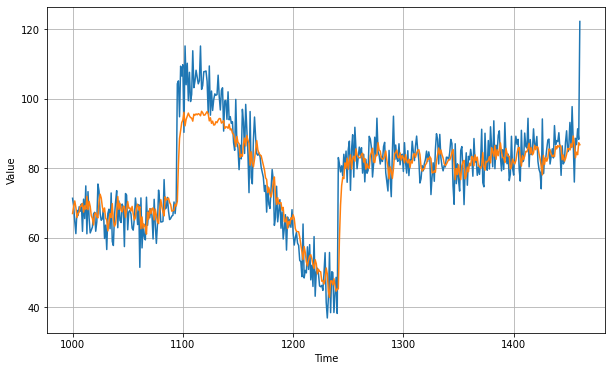

In [16]:
plt.figure(figsize = (10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [17]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.2909775

## Sequence-to-Sequence Forecasting



In [18]:
def seq2seq_window_dataset(series, window_size, batch_size = 32, shuffle_buffer = 1000):
    series = tf.expand_dims(series, axis = -1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [20]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size = 128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences = True, input_shape = [None, 1]),
  keras.layers.SimpleRNN(100, return_sequences = True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])

lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch / 30))

optimizer = keras.optimizers.SGD(learning_rate = 1e-7, momentum = 0.9)

model.compile(
    loss = keras.losses.Huber(),
    optimizer = optimizer,
    metrics = ["mae"]
)

history = model.fit(
    train_set, 
    epochs = 100, 
    callbacks = [lr_schedule]
)

Epoch 1/100
8/8 [==============================] - 2s 41ms/step - loss: 62.2175 - mae: 62.7172 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 36ms/step - loss: 25.5828 - mae: 26.0780 - lr: 1.0798e-07
Epoch 3/100
8/8 [==============================] - 0s 38ms/step - loss: 26.6359 - mae: 27.1318 - lr: 1.1659e-07
Epoch 4/100
8/8 [==============================] - 0s 35ms/step - loss: 20.0008 - mae: 20.4944 - lr: 1.2589e-07
Epoch 5/100
8/8 [==============================] - 0s 36ms/step - loss: 19.0715 - mae: 19.5650 - lr: 1.3594e-07
Epoch 6/100
8/8 [==============================] - 0s 37ms/step - loss: 17.6761 - mae: 18.1653 - lr: 1.4678e-07
Epoch 7/100
8/8 [==============================] - 1s 63ms/step - loss: 16.7536 - mae: 17.2452 - lr: 1.5849e-07
Epoch 8/100
8/8 [==============================] - 1s 67ms/step - loss: 16.1341 - mae: 16.6228 - lr: 1.7113e-07
Epoch 9/100
8/8 [==============================] - 1s 37ms/step - loss: 15.7147 - mae: 16.2040 - lr: 1.8

(1e-07, 0.0001, 0.0, 30.0)

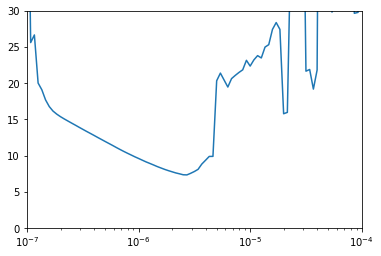

In [21]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [26]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size = 128)
valid_set = seq2seq_window_dataset(x_valid, window_size, batch_size = 128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences = True, input_shape = [None, 1]),
  keras.layers.SimpleRNN(100, return_sequences = True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])

optimizer = keras.optimizers.SGD(learning_rate = 1e-6, momentum = 0.9)

model.compile(
    loss = keras.losses.Huber(),
    optimizer = optimizer,
    metrics = ["mae"]
)

early_stopping = keras.callbacks.EarlyStopping(patience = 50)

model.fit(
    train_set, 
    epochs = 500,
    validation_data = valid_set,
    callbacks = [early_stopping]
)

Epoch 1/500
8/8 [==============================] - 3s 112ms/step - loss: 85.0873 - mae: 85.5863 - val_loss: 46.6154 - val_mae: 47.1136
Epoch 2/500
8/8 [==============================] - 1s 61ms/step - loss: 55.3383 - mae: 55.8367 - val_loss: 65.2547 - val_mae: 65.7547
Epoch 3/500
8/8 [==============================] - 1s 59ms/step - loss: 36.1397 - mae: 36.6361 - val_loss: 37.3466 - val_mae: 37.8462
Epoch 4/500
8/8 [==============================] - 1s 60ms/step - loss: 27.6652 - mae: 28.1599 - val_loss: 17.8394 - val_mae: 18.3339
Epoch 5/500
8/8 [==============================] - 1s 59ms/step - loss: 21.1807 - mae: 21.6723 - val_loss: 13.1374 - val_mae: 13.6276
Epoch 6/500
8/8 [==============================] - 1s 65ms/step - loss: 18.0962 - mae: 18.5869 - val_loss: 12.1892 - val_mae: 12.6809
Epoch 7/500
8/8 [==============================] - 1s 82ms/step - loss: 15.5739 - mae: 16.0629 - val_loss: 13.5399 - val_mae: 14.0337
Epoch 8/500
8/8 [==============================] - 1s 119ms/s

In [30]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 [==============================] - 1s 18ms/step


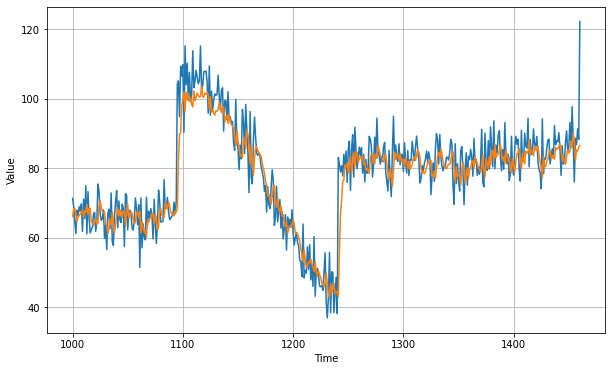

In [31]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [32]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.01696